# Packages import

In [ ]:
import torch
from torch import optim
import numpy as np

from PIL import Image 

import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from pathlib import Path

from torchvision import transforms
from torchvision import models
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.optim import lr_scheduler

import os
import pandas as pd
from time import time

from matplotlib import colors, patches, pyplot as plt
from matplotlib.font_manager import FontProperties
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


# Data download

**i will use kaggle api**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

!pip install --upgrade --force-reinstall --no-deps kaggle
!kaggle competitions download -c journey-springfield

Saving kaggle.json to kaggle.json
     |████████████████████████████████| 61kB 9.4MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=f3edea2c31f535237cf64ecdb48716db2ac00dbad03b158cc107fd4e3f6e2b1a
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12
 96% 502M/521M [00:05<00:00, 81.7MB/s]
100% 521M/521M [00:05<00:00, 107MB/s] 


In [ ]:
!kaggle competitions download -c journey-springfield
!unzip -q /content/journey-springfield.zip -d simpsons
!ls /content/simpsons/

journey-springfield.zip: Skipping, found more recently modified local copy (use --force to force download)
characters_illustration.png  sample_submission.csv  testset  train


# Simpsons' class

In [ ]:
class SimpsonsDataset(Dataset):
    
    def __init__(self, files, mode):
        super().__init__()
        # dataset for download
        self.files = sorted(files)
        # dataset mode by model mode
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index, RESCALE_SIZE=256):
        # transformation by mode and normalization
        transformers = {
            'train': 
            transforms.Compose([
                      transforms.RandomResizedCrop(size=RESCALE_SIZE),
                      transforms.RandomPerspective(distortion_scale=0.1),
                      transforms.RandomRotation(degrees=15),
                      transforms.ColorJitter(),
                      transforms.RandomHorizontalFlip(),
                      transforms.CenterCrop(size=RESCALE_SIZE),  # Imagenet standards
                      transforms.ToTensor(),
                      transforms.Normalize([0.485, 0.456, 0.406],
                                           [0.229, 0.224, 0.225])            
            ]),
            'val':
            transforms.Compose([
                      transforms.Resize(size=RESCALE_SIZE+20),
                      transforms.CenterCrop(size=RESCALE_SIZE),
                      transforms.ToTensor(),
                      transforms.Normalize([0.485, 0.456, 0.406],
                                           [0.229, 0.224, 0.225])
            ]),
            'test':
            transforms.Compose([
                      transforms.Resize(size=RESCALE_SIZE+20),
                      transforms.CenterCrop(size=RESCALE_SIZE),
                      transforms.ToTensor(),
                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        }

        x = self.load_sample(self.files[index])

        # mode -> transformer
        if self.mode == 'train':
            x = transformers['train'](x)
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

        elif self.mode == 'val':
            x = transformers['val'](x)
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

        else:
            x = transformers['test'](x)
            return x
        
    # def _prepare_sample(self, image):
    #     image = image.resize((768, 768))
    #     return np.array(image)

# Statistic

[reference for statistic](https://github.com/WillKoehrsen/pytorch_challenge/blob/master/Transfer%20Learning%20in%20PyTorch.ipynb) 

In [ ]:
# Empty lists
traindir = '/content/simpsons/train/simpsons_dataset/'
categories = []
img_categories = []
n_train = []
hs = []
ws = []

# Iterate through each category
for d in os.listdir(traindir):
    categories.append(d)

    # Number of each image
    train_imgs = os.listdir(traindir + d)
    n_train.append(len(train_imgs))

    # Find stats for train images
    for i in train_imgs:
        img_categories.append(d)
        img = Image.open(traindir + d + '/' + i)
        img_array = np.array(img)
        # Shape
        hs.append(img_array.shape[0])
        ws.append(img_array.shape[1])

# Dataframe of categories
cat_df = pd.DataFrame({'category': categories,
                       'n_train': n_train,
                       }).sort_values('category')

# Dataframe of training images
image_df = pd.DataFrame({
    'category': img_categories,
    'height': hs,
    'width': ws
})

cat_df.sort_values('n_train', ascending=False, inplace=True)

In [ ]:
cat_df.tail(10)

,category,n_train
37,rainier_wolfcastle,45
16,agnes_skinner,42
25,sideshow_mel,40
26,otto_mann,32
23,fat_tony,27
8,gil,27
5,miss_hoover,17
39,disco_stu,8
32,troy_mcclure,8
41,lionel_hutz,3


There are three classes with less than 10 samples.

Let's visualizate this information.

In [ ]:
cat_df.to_csv('/content/cat_info.csv')

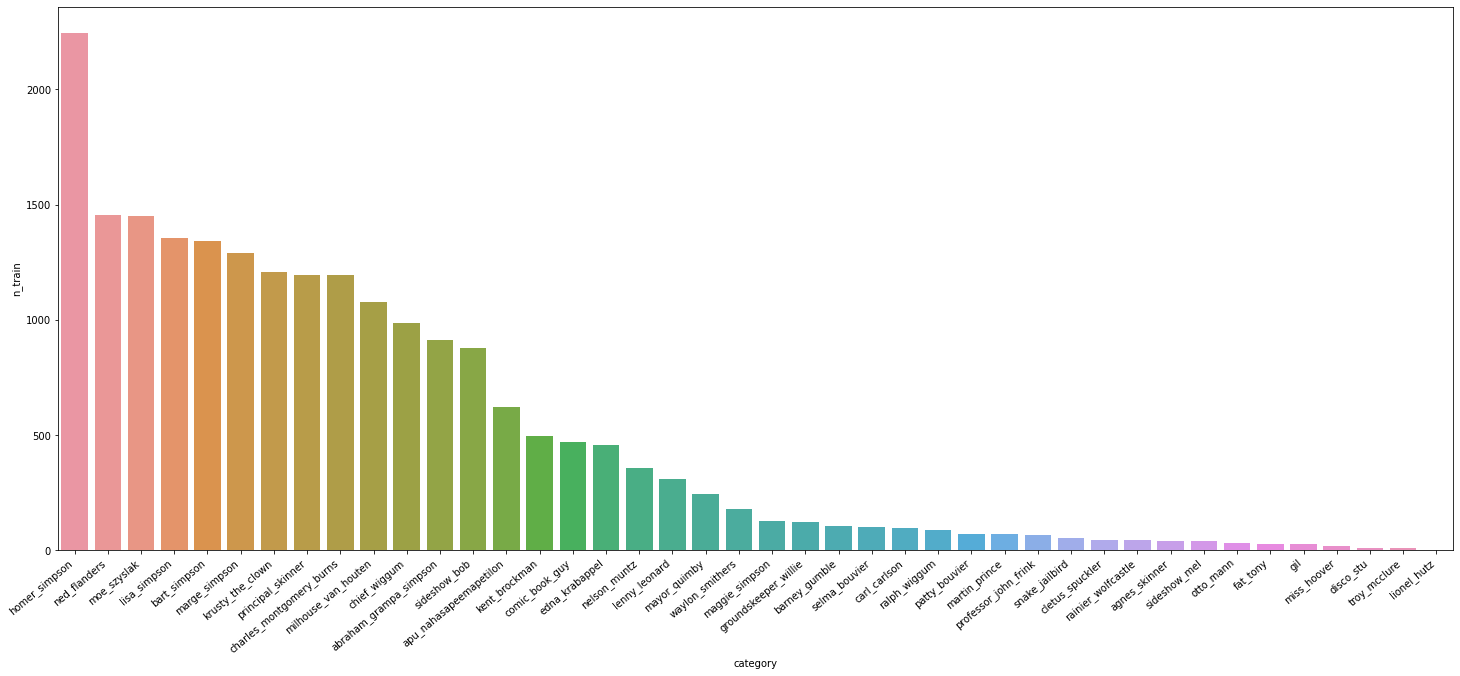

In [ ]:
plt.figure(figsize=(25, 10))
ax = sns.barplot(x = cat_df.category, y = cat_df.n_train)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, horizontalalignment='right')
None

In [ ]:
print ('image_height_min =', image_df.height.min(), ', image_width_min =', image_df.width.min())
print ('image_height_max =', image_df.height.max(), ', image_width_max =', image_df.width.max())

image_height_min = 256 , image_width_min = 256
image_height_max = 1072 , image_width_max = 1912


# Create datasets: train, val, test

In [ ]:
TRAIN_DIR = Path('/content/simpsons/train/')
TEST_DIR = Path('/content/simpsons/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
# different modes of dataset 
DATA_MODES = ['train', 'val', 'test']

# size for rescale
SIZE = 256

# set device
DEVICE = torch.device(device)

split on train and val datasets

In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.2, \
                                          stratify = train_val_labels, random_state = 1)

In [ ]:
train_files_labels = [path.parent.name for path in train_files]
val_files_labels = [path.parent.name for path in val_files]

In [ ]:
print('Train dataset len:', len(train_files_labels), 'n_classes:', len(set(train_files_labels)), '\n'
      'Val dataset len:', len(val_files_labels), 'n_classes:', len(set(val_files_labels)))

Train dataset len: 16746 n_classes: 42 
Val dataset len: 4187 n_classes: 42


In [ ]:
train_dataset = SimpsonsDataset(train_files, mode='train')
val_dataset = SimpsonsDataset(val_files, mode = 'val')
test_dataset = SimpsonsDataset(test_files, mode = 'test')

# Functions for image visualization

Function for visualization random image from train and val datasets

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow for tensors"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)


# grid of random images from train dataset
def imshow_grid(nrows, ncols, mode):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols,figsize=(16, 8), \
                            sharey=True, sharex=True)
    for fig_x in ax.flatten():
        
        if mode == 'train':
          random_characters = int(np.random.uniform(0, len(train_dataset)))
          img, label = train_dataset[random_characters]
          img_label = " ".join(map(lambda x: x.capitalize(),\
                     train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
        
        elif mode == 'val':
          random_characters = int(np.random.uniform(0, len(val_dataset)))
          img, label = val_dataset[random_characters]
          img_label = " ".join(map(lambda x: x.capitalize(),\
                     val_dataset.label_encoder.inverse_transform([label])[0].split('_')))

        imshow(img.data.cpu(), title=img_label,plt_ax=fig_x)

# Have a look on train and val images.

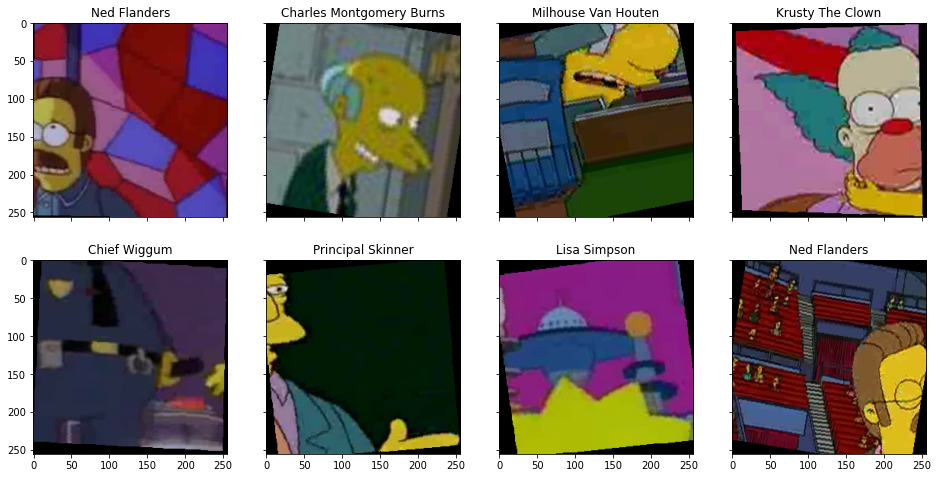

In [ ]:
imshow_grid(2, 4, 'train')

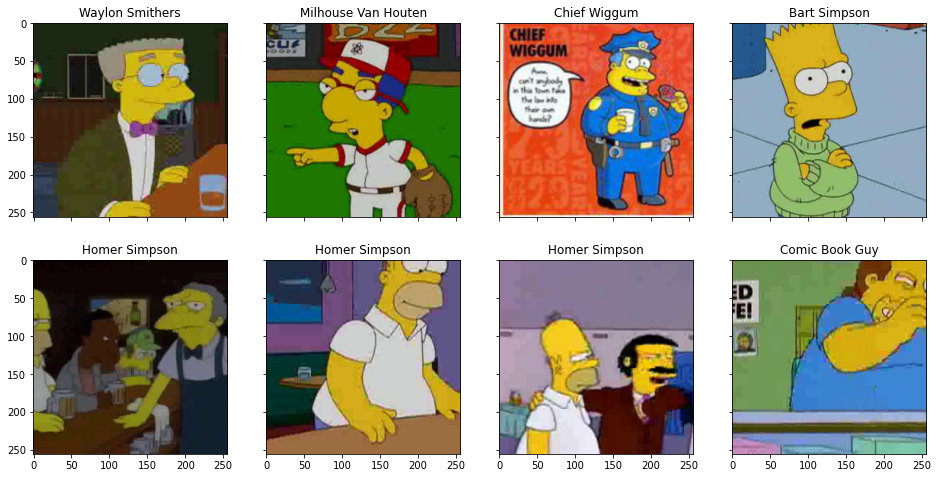

In [ ]:
imshow_grid(2, 4, 'val')

# Functions for model's training 

Epoch training

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    # true loss and accuracy 
    train_loss = running_loss / processed_data 
    train_acc = running_corrects.cpu().numpy() / processed_data

    return train_loss, train_acc

Epoch validation

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval() 
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    val_loss = running_loss / processed_data 
    val_acc = running_corrects.cpu().numpy() / processed_data

    return val_loss, val_acc

# Train loop

In [ ]:
def train(train_dataset, val_dataset, model, epochs, batch_size, criterion, optimizer, scheduler):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0


    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} \n train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc='epoch', total=epochs) as pbar_outer:
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer)

            scheduler.step()
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)

            history.append((train_loss, train_acc, val_loss, val_acc))

            if val_acc > best_acc:
                best_acc = val_acc
                best_model_wts = model.state_dict()

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss, v_loss=val_loss,\
                                           t_acc=train_acc, v_acc=val_acc))
            
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60
    )) 
    print('Best val acc: {:4f}'.format(best_acc))

    # best model's params
    model.load_state_dict(best_model_wts)

    return model, history

loop to train on validation dataset.
I want to try this because we have unbalanced classes.

upd. it doesn't really help.

In [ ]:
def val_training(train_dataset, model, epochs, batch_size, criterion, optimizer, scheduler):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0


    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} train_acc {t_acc:0.4f}"

    with tqdm(desc='epoch', total=epochs) as pbar_outer:
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer)

            scheduler.step()

            history.append((train_loss, train_acc))

            if train_acc > best_acc:
                best_acc = train_acc
                best_model_wts = model.state_dict()

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1,
                                           t_loss=train_loss, 
                                           t_acc=train_acc))
            
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60
    )) 
    print('Best val acc: {:4f}'.format(best_acc))

    # best model's params
    model.load_state_dict(best_model_wts)

    return model, history

probs prediction function

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

Loss visualization

In [ ]:
def show_loss(history):
    loss, acc, val_loss, val_acc = zip(*history)
    plt.figure(figsize=(12, 8))
    plt.plot(loss, label="train")
    plt.plot(val_loss, label="val")
    plt.legend()
    plt.show()

# VGG_16

In [ ]:
vgg_16 = models.vgg16(pretrained=True)
vgg_16

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Training

In [ ]:
# freeze the layers
layers_to_unfreeze = 20
for param in vgg_16.features[:-layers_to_unfreeze].parameters():
    param.requires_grad = False

In [ ]:
# dense in_features
num_features = 25088

# num of classes to classificztion
n_classes = len(np.unique(train_val_labels))

# replace fully-connected layer by our classification linear layer
vgg_16.classifier = nn.Sequential(
                    nn.Linear(in_features=num_features, out_features=4096, bias=True),
                    nn.ReLU(inplace=True),
                    nn.Dropout(p=0.5, inplace=False),
                    nn.Linear(in_features=4096, out_features=4096, bias=True),
                    nn.ReLU(inplace=True),
                    nn.Dropout(p=0.5, inplace=False),
                    nn.Linear(in_features=4096, out_features=n_classes)
)

vgg_16.to(DEVICE)

# cost function
criterion_vgg = nn.CrossEntropyLoss()

# AdamW as optimizer
optimizer_vgg = optim.AdamW(list(vgg_16.features.parameters())[-layers_to_unfreeze:] + 
                            list(vgg_16.classifier.parameters()), lr=3e-4)

# scheduler init
scheduler_vgg = lr_scheduler.StepLR(optimizer_vgg, step_size=7, gamma=0.1)

In [ ]:
%%time
vgg_16, history = train(train_dataset, val_dataset, vgg_16, epochs=20, batch_size=64, 
                        criterion=criterion_vgg,
                        optimizer=optimizer_vgg,
                        scheduler=scheduler_vgg)

In [ ]:
show_loss(history)

saving model

In [ ]:
torch.save(vgg_16.state_dict(), 'vgg_16.pth')

# MobileNetV3_small


In [ ]:
from torchvision import models
mobNet = models.mobilenet_v3_small(pretrained=True)
mobNet

In [ ]:
num_features = 576
n_classes = len(np.unique(train_files_labels))
mobNet.classifier = nn.Sequential(
                                  nn.Linear(num_features, 1024, bias=True),
                                  nn.Hardswish(),
                                  nn.Dropout(p=0.2, inplace=True),
                                  nn.Linear(1024, n_classes, bias=True) 
)

mobNet.to(DEVICE)

criterion_mobNet = nn.CrossEntropyLoss()

optimizer_mobNet = optim.AdamW(mobNet.parameters(), lr=3e-4)

scheduler_mobNet = lr_scheduler.StepLR(optimizer_mobNet, step_size=7, gamma=0.1)

In [ ]:
mobNet, history = train(train_dataset, val_dataset, mobNet, epochs=10, batch_size=64, 
                        criterion=criterion_mobNet,
                        optimizer=optimizer_mobNet,
                        scheduler=scheduler_mobNet
                        )

epoch:  10%|█         | 1/10 [03:50<34:33, 230.34s/it]


Epoch 001 train_loss: 1.6817     val_loss 0.5454 
 train_acc 0.5630 val_acc 0.8543


epoch:  20%|██        | 2/10 [07:40<30:41, 230.16s/it]


Epoch 002 train_loss: 0.8709     val_loss 0.3334 
 train_acc 0.7666 val_acc 0.9195


epoch:  30%|███       | 3/10 [11:29<26:50, 230.07s/it]


Epoch 003 train_loss: 0.6715     val_loss 0.2991 
 train_acc 0.8185 val_acc 0.9262


epoch:  40%|████      | 4/10 [15:17<22:55, 229.18s/it]


Epoch 004 train_loss: 0.6037     val_loss 0.2711 
 train_acc 0.8358 val_acc 0.9410


epoch:  50%|█████     | 5/10 [19:02<18:59, 227.92s/it]


Epoch 005 train_loss: 0.5616     val_loss 0.2299 
 train_acc 0.8498 val_acc 0.9501


epoch:  60%|██████    | 6/10 [22:47<15:08, 227.13s/it]


Epoch 006 train_loss: 0.5154     val_loss 0.2500 
 train_acc 0.8606 val_acc 0.9434


epoch:  70%|███████   | 7/10 [26:31<11:19, 226.40s/it]


Epoch 007 train_loss: 0.4886     val_loss 0.2293 
 train_acc 0.8672 val_acc 0.9522


epoch:  80%|████████  | 8/10 [30:16<07:31, 225.84s/it]


Epoch 008 train_loss: 0.4229     val_loss 0.1970 
 train_acc 0.8887 val_acc 0.9601


epoch:  90%|█████████ | 9/10 [34:00<03:45, 225.14s/it]


Epoch 009 train_loss: 0.4062     val_loss 0.1860 
 train_acc 0.8920 val_acc 0.9613


epoch: 100%|██████████| 10/10 [37:43<00:00, 226.32s/it]


Epoch 010 train_loss: 0.3861     val_loss 0.1833 
 train_acc 0.8950 val_acc 0.9644
Training complete in 37m 43s
Best val acc: 0.964414


In [ ]:
mobNet, history = val_training(val_dataset, mobNet, epochs = 5, batch_size=64,
                               criterion=criterion_mobNet,
                               optimizer=optimizer_mobNet,
                               scheduler=scheduler_mobNet)

epoch:  20%|██        | 1/5 [00:43<02:52, 43.17s/it]


Epoch 001 train_loss: 0.1484 train_acc 0.9709


epoch:  40%|████      | 2/5 [01:26<02:09, 43.16s/it]


Epoch 002 train_loss: 0.1480 train_acc 0.9709


epoch:  60%|██████    | 3/5 [02:09<01:26, 43.10s/it]


Epoch 003 train_loss: 0.1476 train_acc 0.9709


epoch:  80%|████████  | 4/5 [02:52<00:43, 43.04s/it]


Epoch 004 train_loss: 0.1473 train_acc 0.9709


epoch: 100%|██████████| 5/5 [03:35<00:00, 43.02s/it]


Epoch 005 train_loss: 0.1469 train_acc 0.9709
Training complete in 3m 35s
Best val acc: 0.970862


saving model

In [ ]:
torch.save(mobNet.state_dict(), 'mobNetv3small.pth')

# MobNet v3 large

In [ ]:
mobNetlarge = models.mobilenet_v3_large(pretrained=True)
mobNetlarge

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth


MobileNetV3(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): Identity()
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=

In [ ]:
num_features = 960
n_classes = len(np.unique(train_files_labels))
mobNetlarge.classifier = nn.Sequential(
                                  nn.Linear(num_features, 1280, bias=True),
                                  nn.Hardswish(),
                                  nn.Dropout(p=0.2, inplace=True),
                                  nn.Linear(1280, n_classes, bias=True) 
)

mobNetlarge.to(DEVICE)

criterion_mobNetlarge = nn.CrossEntropyLoss()

optimizer_mobNetlarge = optim.AdamW(mobNetlarge.parameters(), lr=3e-4)

scheduler_mobNetlarge = lr_scheduler.StepLR(optimizer_mobNetlarge, step_size=7, gamma=0.1)

In [ ]:
mobNetlarge, history = train(train_dataset, val_dataset, mobNetlarge, epochs=15, batch_size=64, 
                        criterion=criterion_mobNetlarge,
                        optimizer=optimizer_mobNetlarge,
                        scheduler=scheduler_mobNetlarge
                        )

epoch:   7%|▋         | 1/15 [03:13<45:08, 193.47s/it]


Epoch 001 train_loss: 1.3544     val_loss 0.3907 
 train_acc 0.6486 val_acc 0.9045


epoch:  13%|█▎        | 2/15 [06:24<41:45, 192.72s/it]


Epoch 002 train_loss: 0.7201     val_loss 0.2717 
 train_acc 0.8060 val_acc 0.9336


epoch:  20%|██        | 3/15 [09:34<38:23, 191.96s/it]


Epoch 003 train_loss: 0.5659     val_loss 0.2352 
 train_acc 0.8495 val_acc 0.9460


epoch:  27%|██▋       | 4/15 [12:45<35:08, 191.69s/it]


Epoch 004 train_loss: 0.4831     val_loss 0.2117 
 train_acc 0.8729 val_acc 0.9491


epoch:  33%|███▎      | 5/15 [15:56<31:54, 191.46s/it]


Epoch 005 train_loss: 0.4598     val_loss 0.1928 
 train_acc 0.8762 val_acc 0.9563


epoch:  40%|████      | 6/15 [19:06<28:39, 191.04s/it]


Epoch 006 train_loss: 0.4200     val_loss 0.1716 
 train_acc 0.8856 val_acc 0.9644


epoch:  47%|████▋     | 7/15 [22:16<25:24, 190.56s/it]


Epoch 007 train_loss: 0.3952     val_loss 0.2077 
 train_acc 0.8947 val_acc 0.9608


epoch:  53%|█████▎    | 8/15 [25:25<22:11, 190.24s/it]


Epoch 008 train_loss: 0.3213     val_loss 0.1453 
 train_acc 0.9149 val_acc 0.9725


epoch:  60%|██████    | 9/15 [28:35<19:00, 190.13s/it]


Epoch 009 train_loss: 0.3107     val_loss 0.1384 
 train_acc 0.9168 val_acc 0.9733


epoch:  67%|██████▋   | 10/15 [31:45<15:50, 190.01s/it]


Epoch 010 train_loss: 0.2826     val_loss 0.1396 
 train_acc 0.9230 val_acc 0.9737


epoch:  73%|███████▎  | 11/15 [34:55<12:39, 190.00s/it]


Epoch 011 train_loss: 0.2905     val_loss 0.1391 
 train_acc 0.9211 val_acc 0.9747


epoch:  80%|████████  | 12/15 [38:04<09:29, 189.92s/it]


Epoch 012 train_loss: 0.2772     val_loss 0.1378 
 train_acc 0.9254 val_acc 0.9759


epoch:  87%|████████▋ | 13/15 [41:17<06:21, 190.70s/it]


Epoch 013 train_loss: 0.2862     val_loss 0.1384 
 train_acc 0.9234 val_acc 0.9759


epoch:  93%|█████████▎| 14/15 [44:30<03:11, 191.40s/it]


Epoch 014 train_loss: 0.2670     val_loss 0.1407 
 train_acc 0.9258 val_acc 0.9752


epoch: 100%|██████████| 15/15 [47:41<00:00, 190.73s/it]


Epoch 015 train_loss: 0.2651     val_loss 0.1374 
 train_acc 0.9285 val_acc 0.9761
Training complete in 47m 41s
Best val acc: 0.976117


loss

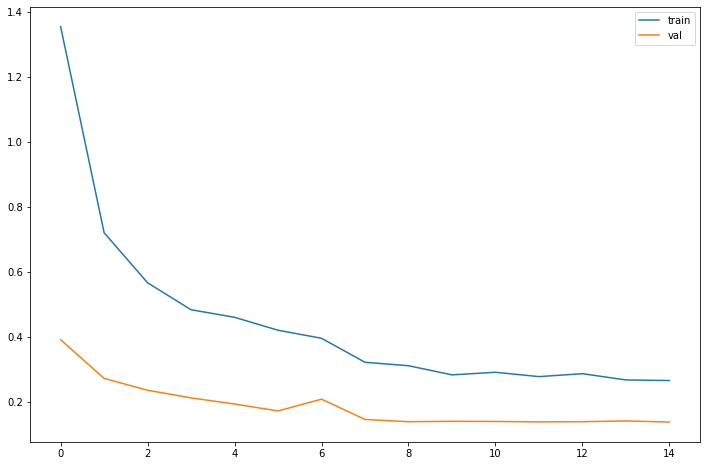

In [ ]:
show_loss(history)

In [ ]:
torch.save(mobNetlarge.state_dict(), 'mobNetLarge.pth')

# Visualization for predictions

Function to predict one image

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    with torch.no_grad():
      inputs = inputs.to(device)
      model.eval()
      logit = model(inputs).cpu()
      probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

F1 score for random sample of validation data

In [ ]:
from sklearn.metrics import f1_score
def f1_val_score(num_samples, model):
  idxs = list(map(int, np.random.uniform(0, len(val_dataset), num_samples)))
  imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

  probs_ims = predict(model, imgs)

  y_pred = np.argmax(probs_ims,-1)
  actual_labels = [val_dataset[id][1] for id in idxs]

  return f1_score(actual_labels, y_pred, average='micro')

predictions visualization

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
def preds_visual(nrows, ncols, model, label_encoder):

  fig, ax = plt.subplots(nrows=nrows, ncols=ncols,figsize=(16, 8), \
                            sharey=True, sharex=True)
  for fig_x in ax.flatten():
      random_characters = int(np.random.uniform(0, len(val_dataset)))
      im_val, label = val_dataset[random_characters]
      img_label = " ".join(map(lambda x: x.capitalize(),\
                    val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
        
        

      imshow(im_val.data.cpu(), title=img_label, plt_ax=fig_x)
        
      actual_text = "Actual : {}".format(img_label)
                
      fig_x.add_patch(patches.Rectangle((0, 231),256,35,color='white'))
      font0 = FontProperties()
      font = font0.copy()
      font.set_family("sans-serif")
      prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
      predicted_proba = np.max(prob_pred)*100
      y_pred = np.argmax(prob_pred)
        
      predicted_label = label_encoder.classes_[y_pred]
      predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
      predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
                
      fig_x.text(1, 231, predicted_text , horizontalalignment='left', fontproperties=font,
                        verticalalignment='top',fontsize=9, color='black',fontweight='bold')

# SimpleCNN

In [ ]:
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(96 * 5 * 5, 96),
            nn.Linear(96, n_classes)
        )
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

# Submit на Kaggle

In [ ]:
# we need our label encoder 
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

dataFrame of predictions

In [ ]:
def submit_df(model, label_encoder, batch_size):
  test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)
  
  probs = predict(model, test_loader)
  preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
  test_filenames = [path.name for path in test_dataset.files]
  
  my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})

  return my_submit

creating file with predictions

In [ ]:
def save_pred(model, name):
    my_submit_mbnet_01 = submit_df(model, label_encoder, 64)
    my_submit_mbnet_01.to_csv('/content/{}.csv'.format(name), index=False)

# Submiting

vgg_16

In [ ]:
vgg_16.load_state_dict(torch.load('/content/vgg_16.pth'))

<All keys matched successfully>

In [ ]:
print('f1_score vgg:', f1_val_score(1000, vgg_16))

f1_score vgg: 0.946


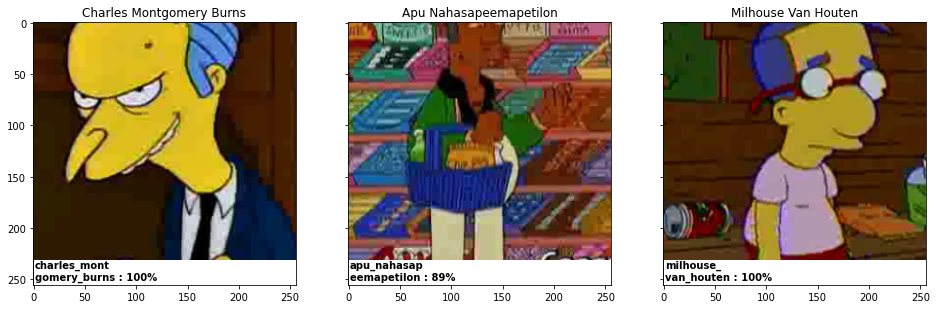

In [ ]:
preds_visual(1, 3, vgg_16, label_encoder)

In [ ]:
save_pred(vgg_16, 'submit_vgg16')

In [ ]:
!kaggle competitions submit -c journey-springfield -f '/content/submit_vgg16.csv' -m 'vgg16'

100% 25.8k/25.8k [00:03<00:00, 6.86kB/s]
Successfully submitted to Journey to Springfield

mobileNet_v3_small

In [ ]:
mobNet.load_state_dict(torch.load('/content/mobNetv3small.pth'))

<All keys matched successfully>

In [ ]:
print('f1_score mobileNet_v3_small:', f1_val_score(1000, mobNet))

f1_score mobileNet_v3_small: 0.968


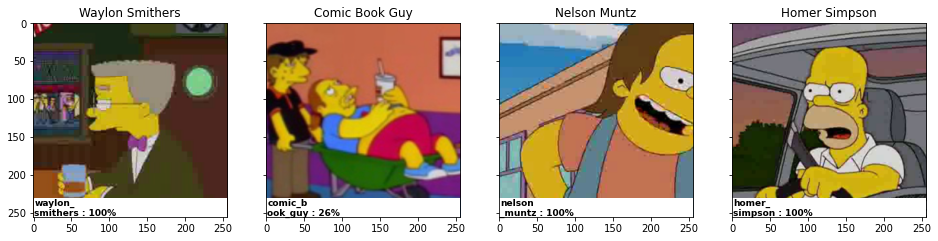

In [ ]:
preds_visual(1, 4, mobNet, label_encoder)

In [ ]:
save_pred(mobNet, 'submit_mobnet')

In [ ]:
!kaggle competitions submit -c journey-springfield -f '/content/submit_mobnet.csv' -m 'mobnet'

100% 25.8k/25.8k [00:03<00:00, 7.72kB/s]
403 - Your team has used its submission allowance (2 of 2). This resets at midnight UTC (2.3 hours from now).


mobileNet_v3_large

In [ ]:
mobNetlarge.load_state_dict(torch.load('/content/mobNetLarge.pth'))

<All keys matched successfully>

In [ ]:
print('f1_score mobileNet_v3_large: ', f1_val_score(1000, mobNetlarge))

f1_score mobileNet_v3_large:  0.98


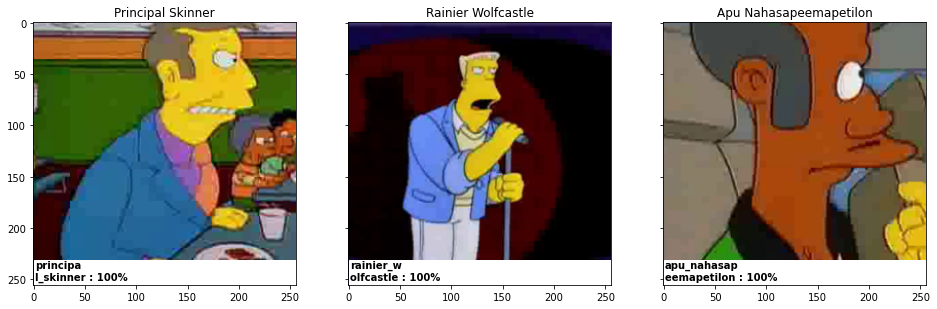

In [ ]:
preds_visual(1, 3, mobNetlarge,label_encoder)

In [ ]:
save_pred(mobNetlarge, 'submit_mobnetlarge')

In [ ]:
!kaggle competitions submit -c journey-springfield -f '/content/submit_mobnetlarge.csv' -m 'mobnet large'

100% 25.8k/25.8k [00:02<00:00, 9.97kB/s]
Successfully submitted to Journey to Springfield

kaggle leaderboard - 0.99574

# For fun

i collected some fun/difficult screenshots from simpsons

In [ ]:
# download my test files
from google.colab import files
files.upload()
!unzip -q /content/mydata.zip -d mytestData

Saving mydata.zip to mydata.zip


In [ ]:
# init dataset
MYTEST_DIR = Path('/content/mytestData')
mytest_files = sorted(list(MYTEST_DIR.rglob('*.jpg')))
train_val_labels = [path.parent.name for path in mytest_files]
mytest_files_labels = [path.parent.name for path in mytest_files]

print('Train dataset len:', len(mytest_files_labels), 'n_classes:', len(set(mytest_files_labels)))

mytest_dataset = SimpsonsDataset(mytest_files, mode = 'val')

Train dataset len: 20 n_classes: 3


In [ ]:
# reinit imshow_grid for my test files
def my_imshow_grid(nrows, ncols):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols,figsize=(16, 8), \
                            sharey=True, sharex=True)
    for fig_x in ax.flatten():
        random_characters = int(np.random.uniform(0, len(mytest_dataset)))
        img, label = mytest_dataset[random_characters]
        img_label = " ".join(map(lambda x: x.capitalize(),\
                    mytest_dataset.label_encoder.inverse_transform([label])[0].split('_')))

        imshow(img.data.cpu(), title=img_label,plt_ax=fig_x)

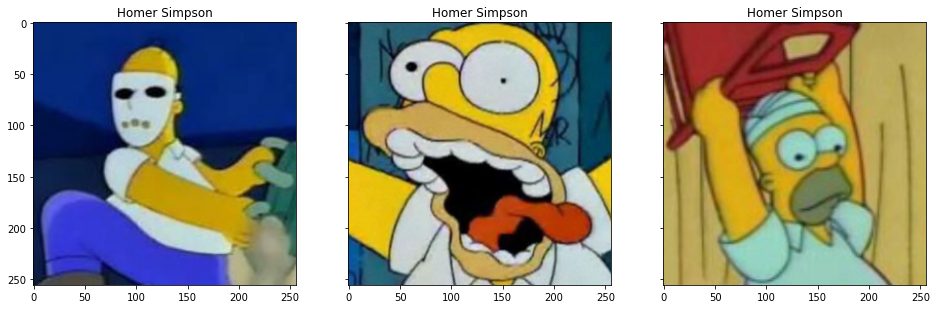

In [ ]:
my_imshow_grid(1, 3)

In [ ]:
# reinit visualization for predictions 
def my_preds_visual(model, label_encoder):

  fig, ax = plt.subplots(nrows=4, ncols=5,figsize=(20, 16), \
                            sharey=True, sharex=True)
  for i, fig_x in enumerate(ax.flatten()):
      
      im_val, label = mytest_dataset[i]
      img_label = " ".join(map(lambda x: x.capitalize(),\
                    mytest_dataset.label_encoder.inverse_transform([label])[0].split('_')))
        
        

      imshow(im_val.data.cpu(), title=img_label, plt_ax=fig_x)
        
      actual_text = "Actual : {}".format(img_label)
                
      fig_x.add_patch(patches.Rectangle((0, 231),256,35,color='white'))
      font0 = FontProperties()
      font = font0.copy()
      font.set_family("sans-serif")
      prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
      predicted_proba = np.max(prob_pred)*100
      y_pred = np.argmax(prob_pred)
        
      predicted_label = label_encoder.classes_[y_pred]
      predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
      predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
                
      fig_x.text(1, 231, predicted_text , horizontalalignment='left', fontproperties=font,
                        verticalalignment='top',fontsize=8, color='black',fontweight='bold')

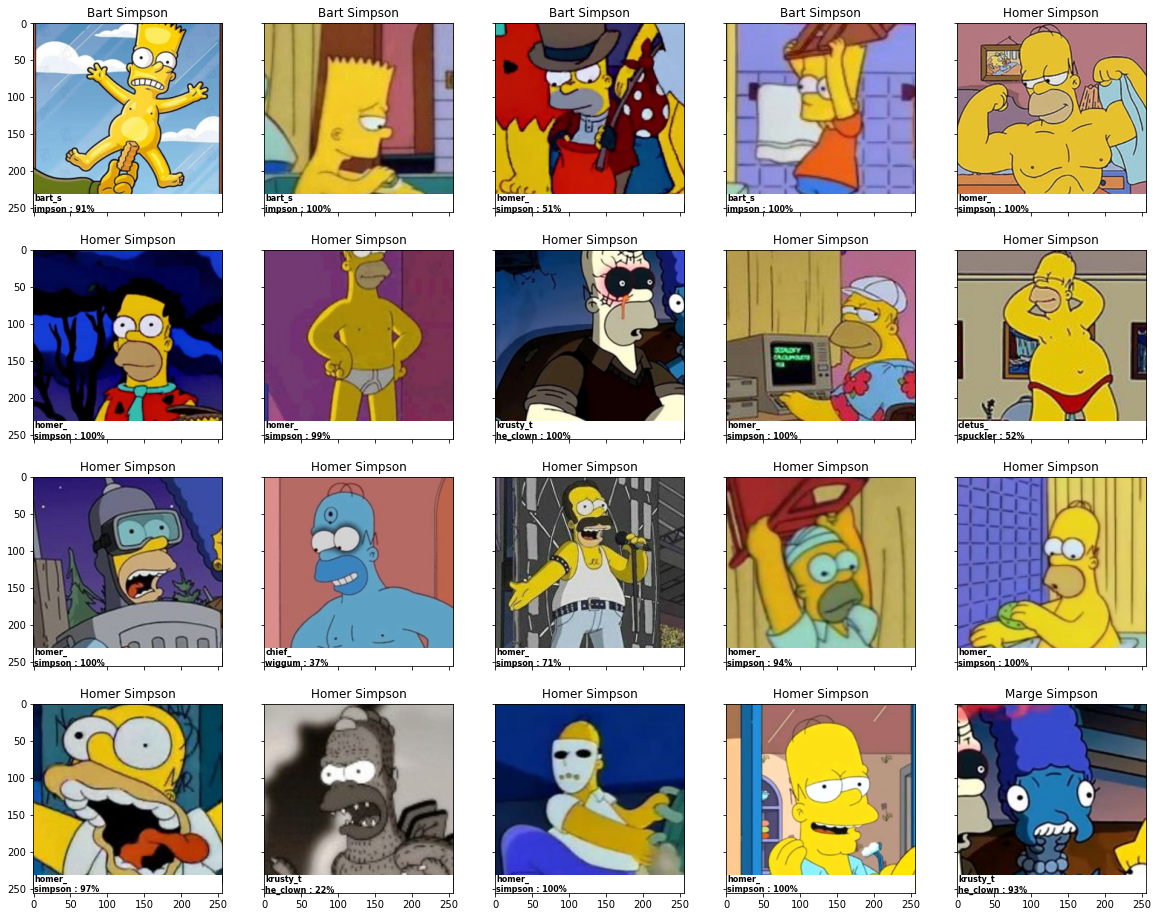

In [ ]:
my_preds_visual(mobNetlarge, label_encoder)

**got quite interesting predictions**